In [1]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from helper import *

In [2]:
path = './data/sample_coco.txt'

lines = []
with open(path) as f:
    lines = f.readlines()

In [3]:
columns = ['id', 'height', 'width', 'x', 'y', 'bbox_width', 'bbox_height']
data = pd.DataFrame(datarestructure(columns,dataList=lines))
data = data.astype(dtype=np.int64)

In [4]:
data['n_height'] = [x/x for x in data.height]
data['n_width'] = [x/x for x in data.width]
data['n_x'] = [x/y for x,y in zip(data.x,data.width)]
data['n_y'] = [x/y for x,y in zip(data.y,data.height)]
data['n_bbox_width'] = [x/y for x,y in zip(data.bbox_width,data.width)]
data['n_bbox_height'] = [x/y for x,y in zip(data.bbox_height,data.height)]

In [32]:
check = data.sample(400,axis=0)
X = check[['n_bbox_width','n_bbox_height']].reset_index()
X = X.drop(columns=['index'])
final_X= check[['n_bbox_width','n_bbox_height']].reset_index().drop(columns=['index'])

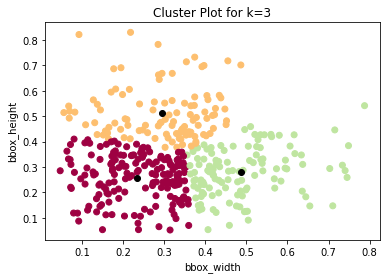

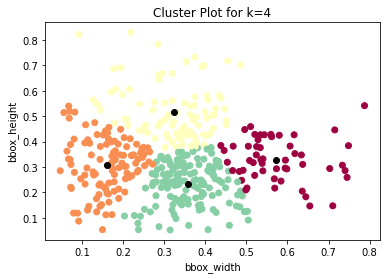

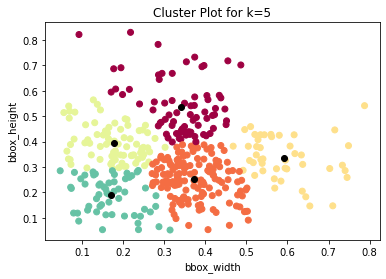

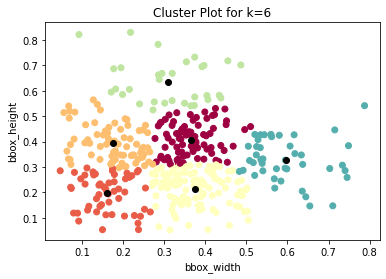

In [61]:
## final_X is for getting cluster values
## X is used for appending anchor box, bb_h_m and bb_w_m

for anchor in np.arange(3,7):
    kmeans = KMeans(n_clusters=anchor, init='k-means++', max_iter=300, n_init=10, random_state=40)
    pred_y = kmeans.fit_predict(final_X)
    centroid = kmeans.cluster_centers_
    cnt =0
    centroid_dict = {}
    centroid_df = pd.DataFrame()
    for i in centroid:
        cnt +=1
        name = '{}'.format(cnt)
        centroid_df[name] = list(1/(abs(X['n_bbox_width'] - i[0])*abs(X['n_bbox_height'] - i[1])))
        centroid_dict[name] = i

    ## Anchor Box Number
    X['AnchorBox#'] = centroid_df.idxmax(axis=1)
    cmap = plt.cm.get_cmap('Spectral')
    plt.scatter(X['n_bbox_width'], X['n_bbox_height'], 
                c=[cmap(float(i)/len(kmeans.cluster_centers_)) for i in kmeans.labels_],cmap='Spectral')
    plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')
    plt.title('Cluster Plot for k={}'.format(anchor))
    plt.xlabel('bbox_width')
    plt.ylabel('bbox_height')
    plt.show()
    width_mul =[]
    height_mul=[]
    for _,i in enumerate(X['AnchorBox#']):
        width_mul.append(centroid_dict[i][0]*X['n_bbox_width'][_])
        height_mul.append(centroid_dict[i][1]*X['n_bbox_height'][_])
    X['width_mul'] = width_mul
    X['height_mul'] = height_mul
    X.to_csv('./data/bbanchor_dataset_centroid{}.csv'.format(anchor),index=False)